In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Loading Data and Quality control

In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("test_AUROC"),
        "AUROC_HQ": summary.get("test_AUROC_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

In [3]:
results_df = pd.DataFrame(results)
results_df = results_df[results_df['group_name'].isin(["full_run_2", "full_run_2_ct"])] # select the right groups
HQ_results = pd.DataFrame(results)
HQ_results = HQ_results[HQ_results['group_name'] == "full_run_2_HQ"]
HQ_results["neg_mode"] = "HQ training"
HQ_results = HQ_results.rename(columns={"AUROC": "AUROC_HQ", "AUROC_HQ": "AUROC"})
HQ_results = HQ_results[HQ_results['celltype'].isin(['A549', 'GM12878', 'K562', 'HepG2'])] # only the right celltypes
# Merge results_df with HQ_results, aligning columns as needed
results_df = pd.concat([results_df, HQ_results], ignore_index=True)

In [4]:
# Exclude rows where neg_mode is 'HQ training' before checking for NaNs in AUROC
mask = results_df["neg_mode"] != "HQ training"
num_nans = results_df.loc[mask, "AUROC"].isna().sum()
print(f"Number of NaNs in AUROC (excluding HQ training): {num_nans}")
results_df.loc[mask & results_df["AUROC"].isna()]

Number of NaNs in AUROC (excluding HQ training): 1


,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss
1679,hardy-star-6843,TCF12,HepG2,neighbors,5.0,full_run_2,NaN,NaN,0.777954


There should be no NaNs!!

In [5]:
# Filter out entries where AUROC_HQ == 0 -> probably an issue with the cross val split 
filtered_out_count = results_df[(results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna())].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[~((results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna()))]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0 or NaN: {filtered_out_count}")

Number of entries where AUROC_HQ == 0 or NaN: 1


Also no 0's!!

In [6]:
results_df["celltype_TF"] = results_df["celltype"]+"_"+results_df["TF"]
output = results_df["celltype_TF"].value_counts()
output.to_dict()

{'GM12878_CTCF': 36,
 'GM12878_YY1_(SC-281)': 36,
 'GM12878_SRF': 36,
 'GM12878_Mxi1_(AF4185)': 36,
 'GM12878_Egr-1': 36,
 'GM12878_TBP': 36,
 'GM12878_MAZ_(ab85725)': 36,
 'GM12878_ELK1_(1277-1)': 36,
 'GM12878_SIX5': 36,
 'GM12878_USF-1': 36,
 'GM12878_ATF2_(SC-81188)': 36,
 'GM12878_ELF1_(SC-631)': 36,
 'GM12878_RFX5_(200-401-194)': 36,
 'GM12878_SP1': 36,
 'GM12878_Pbx3': 36,
 'GM12878_MEF2A': 36,
 'GM12878_TCF12': 36,
 'GM12878_Max': 36,
 'GM12878_NF-YB': 36,
 'GM12878_USF2': 36,
 'GM12878_Znf143_(16618-1-AP)': 36,
 'GM12878_ZEB1_(SC-25388)': 36,
 'GM12878_STAT5A_(SC-74442)': 36,
 'GM12878_NFIC_(SC-81335)': 36,
 'GM12878_Nrf1': 36,
 'GM12878_CEBPB_(SC-150)': 36,
 'GM12878_ETS1': 36,
 'GM12878_ZBTB33': 36,
 'GM12878_RXRA': 36,
 'GM12878_FOXM1_(SC-502)': 36,
 'HepG2_MafF_(M8194)': 36,
 'HepG2_FOSL2': 36,
 'HepG2_YY1_(SC-281)': 36,
 'HepG2_JunD': 36,
 'GM12878_ATF3': 36,
 'GM12878_NF-YA': 36,
 'GM12878_IKZF1_(IkN)_(UCLA)': 36,
 'GM12878_JunD': 36,
 'GM12878_ZZZ3': 36,
 'GM12878_ZNF27

There really shouldn't be any with less runs, so check if something is wrong!!

In [7]:
# Filter out TFs with less than 36 samples
results_df = results_df.groupby('celltype_TF').filter(lambda x: len(x) >= 36) #! ONLY TAKE THE 4 BIG CELL TYPES

In [8]:
results_df["celltype"].value_counts() 

celltype
GM12878    1296
K562       1296
HepG2      1188
A549        504
Name: count, dtype: int64

In [9]:
results_df["TF-neg_mode"] = results_df["TF"]+"_"+results_df["neg_mode"]
results_df["TF-neg_mode-celltype"] = results_df["TF"]+"_"+results_df["neg_mode"]+"_"+results_df["celltype"]

In [10]:
tf_per_celltype = results_df.groupby("celltype")["TF"].nunique()
print(tf_per_celltype)

celltype
A549       14
GM12878    36
HepG2      33
K562       36
Name: TF, dtype: int64


In [11]:
results_df["neg_mode"].value_counts()

neg_mode
dinucl_sampled     714
dinucl_shuffled    714
shuffled           714
neighbors          714
celltype           714
HQ training        714
Name: count, dtype: int64

In [12]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]

In [13]:
import pickle

with open("/data/home/natant/Negatives/TFBS_negatives/testing_ground/20250613_NUMBER_OF_POSITIVES_PER_GROUP.pkl", "rb") as f:
    number_of_positives = pickle.load(f)
# Convert the nested dictionary 'number_of_positives' into a pandas DataFrame
number_of_positives_df = (
    pd.DataFrame([
        {"celltype": ct, "TF": tf, "positives 1": vals[0], "positives 2": vals[1], "positives 3": vals[2]}
        for ct, tf_dict in number_of_positives.items()
        for tf, vals in tf_dict.items()
    ])
)
number_of_positives_df

,celltype,TF,positives 1,positives 2,positives 3
0,MCF-7,CTCF,7124,5733,8144
1,MCF-7,TCF7L2,2909,2949,4439
2,MCF-7,ZNF217,2911,2775,4259
3,MCF-7,GATA3_(SC-268),1853,1606,2624
4,GM12878,CTCF,12222,12053,15832
...,...,...,...,...,...
127,A549,USF-1,2170,2457,3821
128,A549,ETS1,1535,1503,2503
129,A549,SIX5,1488,1318,2109
130,A549,ZBTB33,1896,2039,3222


In [14]:
from itertools import permutations
all_orderings = list(permutations(["part1", "part2", "part3"]))
ordering_dict = {i: ordering[0] for i, ordering in enumerate(all_orderings)}
# Map cross_val_set to the corresponding positives column using two dictionaries
crossval_to_part = ordering_dict  # e.g., {0: 'part1', 1: 'part1', 2: 'part2', ...}
part_to_col = {"part1": "positives 1", "part2": "positives 2", "part3": "positives 3"}

def lookup_num_training_positives(row):
    part = crossval_to_part[int(row['cross_val_set'])]
    part_col = part_to_col.get(part)
    match = number_of_positives_df[
        (number_of_positives_df['celltype'] == row['celltype']) &
        (number_of_positives_df['TF'] == row['TF'])
    ]
    if not match.empty and part_col is not None:
        return match.iloc[0][part_col]
    else:
        return np.nan

results_df["num_training_positives"] = results_df.apply(lookup_num_training_positives, axis=1)


## Dataframe 1: results_df
Contains all the results, without averaging the different cross_val folds

In [15]:
# Group by TF, celltype, and neg_mode, then average AUROC and AUROC_HQ
grouped_avg = results_df.groupby(['TF', 'celltype', 'neg_mode'], as_index=False)[['AUROC', 'AUROC_HQ', 'num_training_positives']].mean()
grouped_avg["TF-neg_mode"] = grouped_avg["TF"] + "-" + grouped_avg["neg_mode"]
grouped_avg

,TF,celltype,neg_mode,AUROC,AUROC_HQ,num_training_positives,TF-neg_mode
0,ARID3A_(NB100-279),HepG2,HQ training,NaN,0.731541,5873.666667,ARID3A_(NB100-279)-HQ training
1,ARID3A_(NB100-279),HepG2,celltype,0.641804,0.599579,5873.666667,ARID3A_(NB100-279)-celltype
2,ARID3A_(NB100-279),HepG2,dinucl_sampled,0.766061,0.702276,5873.666667,ARID3A_(NB100-279)-dinucl_sampled
3,ARID3A_(NB100-279),HepG2,dinucl_shuffled,0.706626,0.569683,5873.666667,ARID3A_(NB100-279)-dinucl_shuffled
4,ARID3A_(NB100-279),HepG2,neighbors,0.718460,0.682193,5873.666667,ARID3A_(NB100-279)-neighbors
...,...,...,...,...,...,...,...
709,Znf143_(16618-1-AP),K562,celltype,0.782408,0.774070,9686.666667,Znf143_(16618-1-AP)-celltype
710,Znf143_(16618-1-AP),K562,dinucl_sampled,0.891440,0.835624,9686.666667,Znf143_(16618-1-AP)-dinucl_sampled
711,Znf143_(16618-1-AP),K562,dinucl_shuffled,0.873682,0.809226,9686.666667,Znf143_(16618-1-AP)-dinucl_shuffled
712,Znf143_(16618-1-AP),K562,neighbors,0.844760,0.804817,9686.666667,Znf143_(16618-1-AP)-neighbors


## Dataframe 2: grouped_avg
Contains all the results, with averaged AUROC and AUROC_HQ over the different cross_val_folds

In [16]:
import os

# Define the folder path
folder_path = "/data/home/natant/Negatives/Runs/full_run_1/motifs"

# Get a list of all CSV files in the folder, excluding HEK293 and MCF-7
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f not in ['HEK293.csv', 'MCF-7.csv']]

# Load each CSV file into a dictionary of DataFrames
dataframes = {os.path.splitext(f)[0]: pd.read_csv(os.path.join(folder_path, f)) for f in csv_files}
dataframes = {name: df.rename(columns={"Unnamed: 0": "TF"}) for name, df in dataframes.items()}

# Print the names of the loaded DataFrames
print(f"Loaded DataFrames: {list(dataframes.keys())}")

Loaded DataFrames: ['A549', 'GM12878', 'K562', 'HepG2']


In [17]:
# Initialize an empty list to store DataFrames
merged_dfs = []

# Iterate through the CSV files and process each one
for celltype in csv_files:
    # Extract the cell type name (without the .csv extension)
    celltype_name = os.path.splitext(celltype)[0]
    
    # Load the DataFrame for the current cell type
    df = dataframes[celltype_name]
    
    # Average AUROC_1, AUROC_2, AUROC_3 into a new column "AUROC"
    df["AUROC"] = df[["AUROC_1", "AUROC_2", "AUROC_3"]].mean(axis=1)
    
    # Keep only the relevant columns
    df = df[["TF", "AUROC"]].copy()
    
    # Add additional columns for cell type and neg_mode
    df['celltype'] = celltype_name
    df['neg_mode'] = 'motif'
    
    # Append the processed DataFrame to the list
    merged_dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
motif_df = pd.concat(merged_dfs, ignore_index=True)


In [18]:
# Find TFs in results_df that are not present in motif_df for each celltype
motif_celltypes = motif_df["celltype"].unique()
motif_tfs = motif_df["TF"].unique()

# For each celltype, report missing TFs
report = {}
for ct in motif_celltypes:
    tfs_in_results = set(results_df[results_df["celltype"] == ct]["TF"].unique())
    tfs_in_motif = set(motif_df[motif_df["celltype"] == ct]["TF"].unique())
    missing_tfs = tfs_in_results - tfs_in_motif
    report[ct] = {
        "total_TFs_in_results": len(tfs_in_results),
        "TFs_with_motif": len(tfs_in_motif),
        "TFs_missing_motif": len(missing_tfs),
        "missing_TFs": list(missing_tfs)
    }

# Print the report
for ct, stats in report.items():
    print(f"Celltype: {ct}")
    print(f"  Total TFs in results_df: {stats['total_TFs_in_results']}")
    print(f"  TFs with motif: {stats['TFs_with_motif']}")
    print(f"  TFs missing motif: {stats['TFs_missing_motif']}")
    print(f"  Missing TFs: {stats['missing_TFs']}\n")

# How many rows are removed from results_df when subsetting to TFs and celltypes present in motif_df
initial_rows = results_df.shape[0]
subset_df = results_df[(results_df['celltype'].isin(motif_celltypes)) & (results_df['TF'].isin(motif_tfs))]
removed_rows = initial_rows - subset_df.shape[0]
print(f"Rows in results_df before subsetting: {initial_rows}")
print(f"Rows in results_df after subsetting: {subset_df.shape[0]}")
print(f"Rows removed: {removed_rows}")

Celltype: A549
  Total TFs in results_df: 14
  TFs with motif: 12
  TFs missing motif: 2
  Missing TFs: ['SIX5', 'USF-1']

Celltype: GM12878
  Total TFs in results_df: 36
  TFs with motif: 30
  TFs missing motif: 6
  Missing TFs: ['RXRA', 'SIX5', 'STAT5A_(SC-74442)', 'TBP', 'ZZZ3', 'USF-1']

Celltype: K562
  Total TFs in results_df: 36
  TFs with motif: 30
  TFs missing motif: 6
  Missing TFs: ['SIX5', 'STAT5A_(SC-74442)', 'ATF1_(06-325)', 'SETDB1', 'TBP', 'USF-1']

Celltype: HepG2
  Total TFs in results_df: 33
  TFs with motif: 30
  TFs missing motif: 4
  Missing TFs: ['TBP', 'RXRA', 'ARID3A_(NB100-279)', 'USF-1']

Rows in results_df before subsetting: 4284
Rows in results_df after subsetting: 3636
Rows removed: 648


In [19]:
subset_df = grouped_avg[(grouped_avg['celltype'].isin(motif_df["celltype"].unique())) & (grouped_avg['TF'].isin(motif_df['TF'].unique()))]
# Concatenate subset_df and melted_df, keeping only the specified columns
subset_df = subset_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']]
motif_df = motif_df.rename(columns={"AUROC": "AUROC_HQ"})
fused_df = pd.concat([subset_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']], motif_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']]])

# Reset the index for the new DataFrame
fused_df.reset_index(drop=True, inplace=True)

## Dataframe 3: fused_df
Contains the subset of TFs for which we have motifs. Also contains the predicts for the motifs

# Figure: HQ and normal performance

In [20]:
color_list = [
    "#ff595e", "#ff924c", "#ffca3a", "#c5ca30", "#8ac926",
    "#52a675", "#1982c4", "#4267ac", "#6a4c93", "#b5a6c9"
]

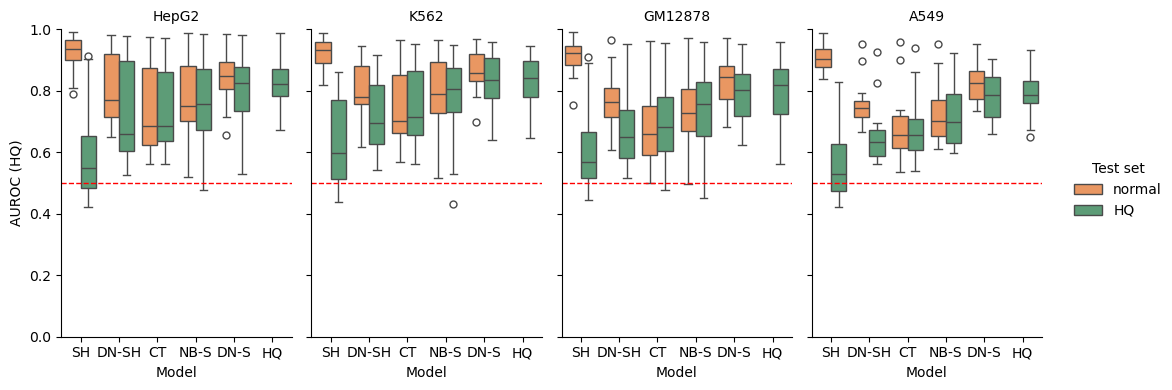

In [21]:
melted_group_avg = pd.melt(
    grouped_avg.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode', "celltype", 'TF'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_group_avg['auroc_metric'] = melted_group_avg['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'motif': "PWM",
    'celltype': 'CT',
    'HQ training': 'HQ'
}
melted_group_avg['neg_mode_short'] = melted_group_avg['neg_mode'].map(neg_mode_labels)
# Only use HQ rows for ordering
hq_rows = melted_group_avg[melted_group_avg['auroc_metric'] == 'HQ']
mean_per_mode = hq_rows.groupby("neg_mode_short")["AUROC_value"].mean().sort_values(ascending=True)
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
melted_group_avg["neg_mode_short"] = pd.Categorical(melted_group_avg["neg_mode_short"], categories=neg_mode_order, ordered=True)


palette = {'HQ': color_list[5], 'normal': color_list[1]}
g = sns.catplot(
    data=melted_group_avg,
    x='neg_mode_short',
    col='celltype',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    height=4,
    aspect=0.6,
    palette=palette,
    dodge=True,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC (HQ)")
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
g._legend.set_title("Test set")
g.set(ylim=(0, 1))
for ax, celltype in zip(g.axes.flatten(), g.col_names):
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1746426/2483973488.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1746426/2483973488.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1746426/2483973488.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1746426/2483973488.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


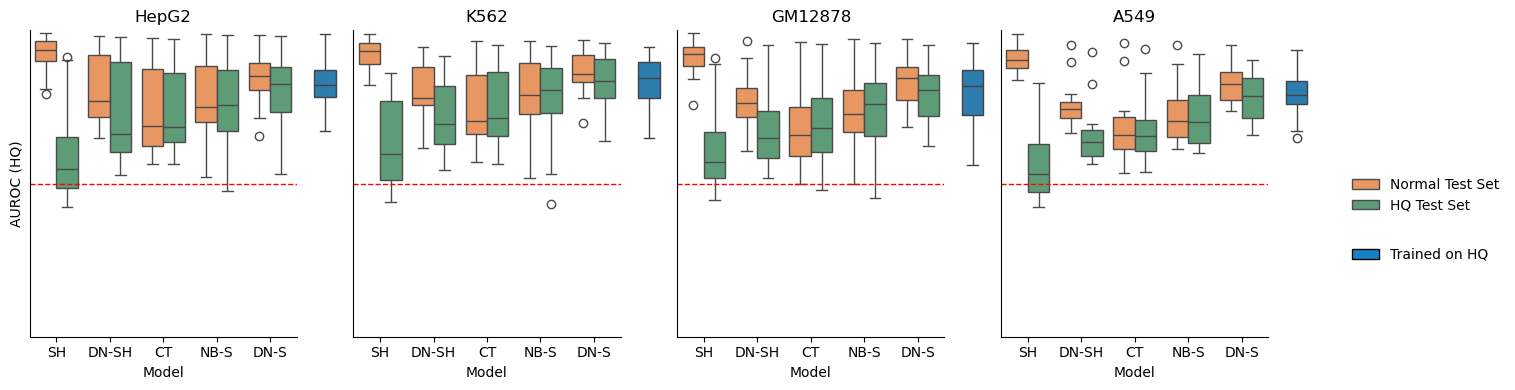

In [22]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(1, 8, figsize=(14, 4), sharey=True, width_ratios=[1, 0.1] * 4)
cts = melted_group_avg["celltype"].unique()
plot_df = melted_group_avg.copy()
plot_df["neg_mode_short"] = plot_df["neg_mode_short"].cat.remove_categories(["HQ"])
legend_handles = None
legend_labels = None
palette = {'HQ': color_list[5], 'normal': color_list[1]}
# In your plotting loop, update this block:
for i, ct in enumerate(cts):
    ct_df = plot_df[(plot_df["celltype"] == ct) & (plot_df["neg_mode_short"] != "HQ")]
    sns.boxplot(
        data=ct_df,
        ax=ax[i*2],
        x='neg_mode_short',
        y='AUROC_value',
        hue='auroc_metric',
        palette=palette,
        dodge=True
    )
    ax[i*2].set_title(ct)
    ax[i*2].set_xlabel("Model")
    if i == 0:
        ax[i*2].set_ylabel("AUROC (HQ)")
    else:
        ax[i*2].set_ylabel("")
        ax[i*2].set_yticklabels([])
        ax[i*2].set_yticks([])
    ax[i*2].axhline(0.5, linestyle='--', color='red', linewidth=1)
    ax[i*2].set_ylim(0, 1)
    ax[i*2].spines['top'].set_visible(False)
    ax[i*2].spines['right'].set_visible(False)
    handles, labels = ax[i*2].get_legend_handles_labels()
    if legend_handles is None and handles:
        legend_handles, legend_labels = handles, labels
    ax[i*2].get_legend().remove()


plot_df = melted_group_avg.copy()
plot_df["neg_mode_short"] = plot_df["neg_mode_short"].cat.remove_unused_categories()
plot_df["neg_mode_short"] = plot_df["neg_mode_short"].cat.set_categories(["HQ"])
palette = {'HQ': color_list[6]}
for i, ct in enumerate(cts):
    ct_df = plot_df[(plot_df["celltype"] == ct) & (plot_df["neg_mode_short"] == "HQ")]
    sns.boxplot(
        data=ct_df,
        ax=ax[i*2 + 1],
        x='neg_mode_short',
        y='AUROC_value',
        dodge=True,
        palette=palette,
    )
    sns.despine(ax=ax[i*2 + 1], bottom=True, left=True)
    ax[i*2 + 1].set_ylabel("")
    ax[i*2 + 1].set_xlabel("")
    ax[i*2 + 1].set_xticklabels([])
    ax[i*2 + 1].set_xticks([])
    ax[i*2 + 1].set_yticklabels([])
    ax[i*2 + 1].set_yticks([])
    ax[i*2 + 1].set_ylim(0, 1)
    ax[i*2 + 1].spines['top'].set_visible(False)
    ax[i*2 + 1].spines['right'].set_visible(False)

if legend_handles is not None:
    # Change legend labels
    legend_labels = ['Normal Test Set', 'HQ Test Set']
    legend = fig.legend(
        legend_handles, legend_labels,
        loc="center left", bbox_to_anchor=(1.01, 0.5),
        frameon=False, title=""
    )
    hq_patch = Patch(facecolor=palette['HQ'], edgecolor='black', label='HQ (separate box)')
    fig.legend(
        [hq_patch], ['Trained on HQ'],
        loc="center left", bbox_to_anchor=(1.01, 0.35), frameon=False, title=""
    )

ax[0].tick_params(labelleft=True, left=True)
ax[0].set_ylabel("AUROC (HQ)")  # Redundant but safe
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()


Okay I still need to add label ticks and labels to the Y axis! Also remove the borders around the legend. Maybe also remove the titel from the normal legend and change the items to Normal test set, and HQ test set

## Figure: AUROC deltas

In [23]:
neg_mode_colors = {neg_mode_labels[key]:color_list[i] for i,key in enumerate(neg_mode_labels.keys())}

In [24]:
results_df["neg_mode_short"] = results_df["neg_mode"].map(neg_mode_labels)

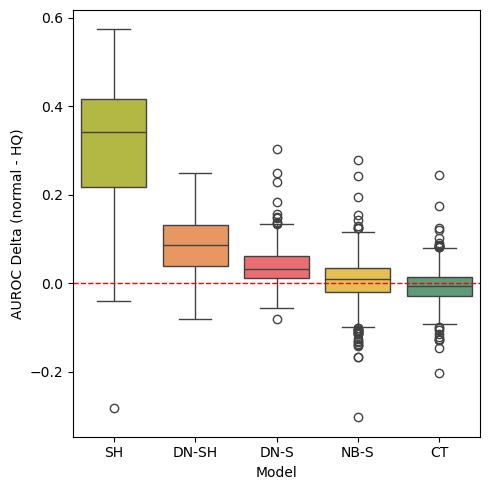

In [25]:

# Compute mean AUROC_delta per neg_mode (excluding HQ training)
mean_delta_per_mode = (
    results_df[results_df["neg_mode_short"] != "HQ"]
    .groupby("neg_mode_short")["AUROC_delta"]
    .mean()
    .sort_values(ascending=False)
)
neg_mode_order = mean_delta_per_mode.index.tolist()

# Set categorical order for plotting
plot_df = results_df[results_df["neg_mode_short"] != "HQ"].copy()
plot_df["neg_mode_short"] = pd.Categorical(plot_df["neg_mode_short"], categories=neg_mode_order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(ax=ax,data=plot_df, x='neg_mode_short', y='AUROC_delta', hue='neg_mode_short', palette=neg_mode_colors)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("Model")
ax.set_ylabel("AUROC Delta (normal - HQ)")
plt.tight_layout()
plt.show()

## Figure: HQ training vs dinucl_sampled

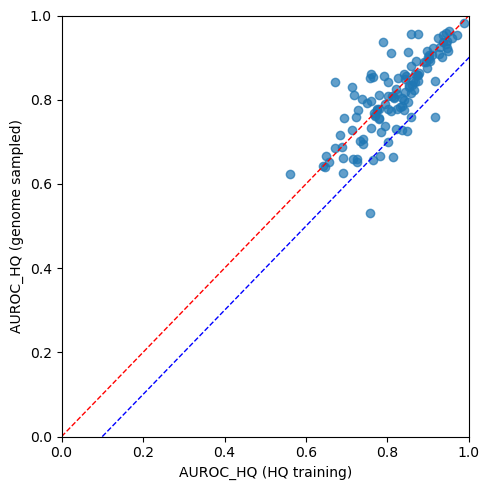

In [26]:
import matplotlib.pyplot as plt

# Filter for HQ training and dinucl_sampled (genome_sampled) models
hq_df = grouped_avg[grouped_avg["neg_mode"] == "HQ training"][["TF", "celltype", "AUROC_HQ"]].rename(columns={"AUROC_HQ": "AUROC_HQ_HQ"})
genome_df = grouped_avg[grouped_avg["neg_mode"] == "dinucl_sampled"][["TF", "celltype", "AUROC_HQ"]].rename(columns={"AUROC_HQ": "AUROC_HQ_genome"})

# Merge on TF and celltype to align the two modes
merged = pd.merge(hq_df, genome_df, on=["TF", "celltype"])

plt.figure(figsize=(5, 5))
plt.scatter(merged["AUROC_HQ_HQ"], merged["AUROC_HQ_genome"], alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='y=x')
plt.plot([0.1, 1.1], [0, 1], 'b--', linewidth=1, label='y=x-0.1')  # Parallel line shifted by 0.1 on x-axis
plt.xlabel("AUROC_HQ (HQ training)")
plt.ylabel("AUROC_HQ (genome sampled)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Figure: Motif performance

In [46]:
nice_names = {
    "dinucl_sampled": "Genome Sampled",
    "dinucl_shuffled": "Dinucl Shuffled",
    "neighbors": "Neighborhood Sampled",
    "shuffled": "Shuffled",
    "motif": "PWM",
    "celltype": "Celltype Sampled",
    "HQ training": "HQ"
}

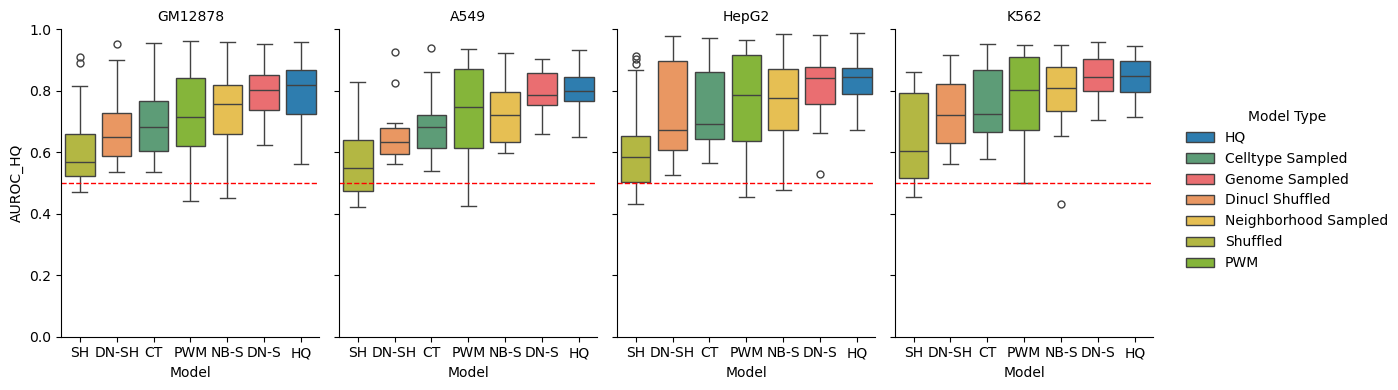

In [48]:
# Compute mean AUROC_HQ per neg_mode_short for ordering
fused_df["neg_mode_short"] = fused_df["neg_mode"].map(neg_mode_labels)
mean_per_mode = fused_df.groupby("neg_mode_short")["AUROC_HQ"].mean().sort_values()
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
fused_df["neg_mode_short"] = pd.Categorical(fused_df["neg_mode_short"], categories=neg_mode_order, ordered=True)

# Add a column with nice names for neg_mode
fused_df["neg_mode_nice"] = fused_df["neg_mode"].map(nice_names)

g = sns.catplot(
    data=fused_df,
    x='neg_mode_short',
    col='celltype',
    y='AUROC_HQ',
    hue='neg_mode_nice',
    kind='box',
    height=4,
    aspect=0.6,
    palette={nice_names[k]: color_list[i] for i, k in enumerate(neg_mode_labels.keys())}
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC_HQ")
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
g._legend.set_title("Model Type")
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
plt.tight_layout()
plt.show()


## Figure: Motif vs Dincul shuffled

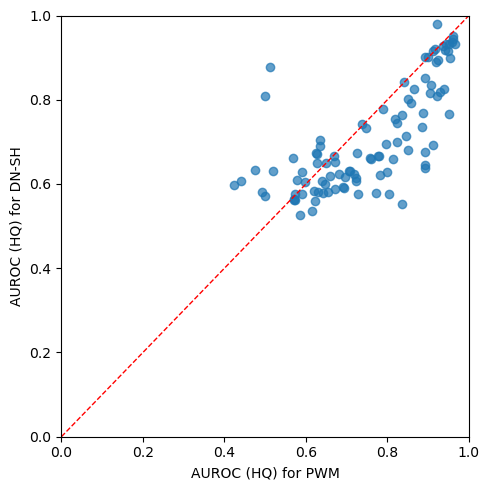

In [28]:
import matplotlib.pyplot as plt

# Filter fused_df for only 'motif' and 'dinucl_shuffled' neg_mode
compare_modes = ['motif', 'dinucl_shuffled']
df1 = fused_df[fused_df['neg_mode'] == 'motif'][['TF', 'celltype', 'AUROC_HQ']]
df2 = fused_df[fused_df['neg_mode'] == 'dinucl_shuffled'][['TF', 'celltype', 'AUROC_HQ']]

# Merge on TF and celltype to align the two modes
merged = pd.merge(
    df1, df2,
    on=['TF', 'celltype'],
    suffixes=('_motif', '_dinucl_shuffled')
)

plt.figure(figsize=(5, 5))
plt.scatter(
    merged['AUROC_HQ_motif'],
    merged['AUROC_HQ_dinucl_shuffled'],
    alpha=0.7
)
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='y=x')
plt.xlabel('AUROC (HQ) for PWM')
plt.ylabel('AUROC (HQ) for DN-SH')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Figure: Dataset size

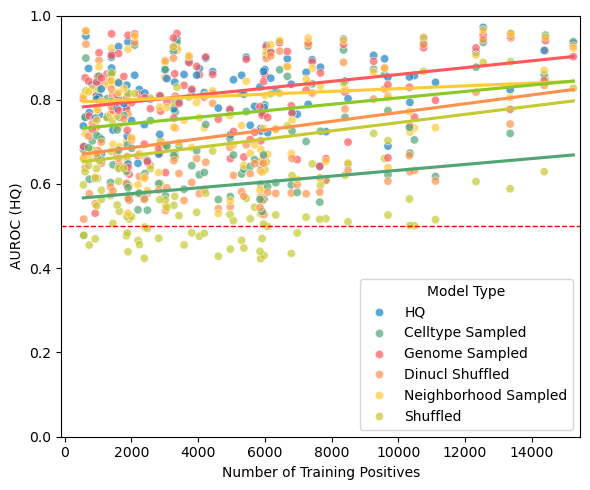

In [ ]:
plt.figure(figsize=(6, 5))
# Filter out datapoints with more than 16000 positives and less than 1000 positives
plot_data = grouped_avg[(grouped_avg["num_training_positives"] <= 16000) & (grouped_avg["num_training_positives"] >= 500)]

# Prepare color palette for nice_names
palette = {nice_names[k]: color_list[i] for i, k in enumerate(neg_mode_labels.keys())}

sns.scatterplot(
    data=plot_data,
    x="num_training_positives",
    y="AUROC_HQ",
    hue=plot_data["neg_mode"].map(nice_names),
    palette=palette,
    alpha=0.7
)

# Add trend lines for each neg_mode using nice names and colors
for neg_mode in plot_data["neg_mode"].unique():
    label = nice_names[neg_mode]
    color = palette[label]
    subset = plot_data[plot_data["neg_mode"] == neg_mode]
    sns.regplot(
        data=subset,
        x="num_training_positives",
        y="AUROC_HQ",
        scatter=False,
        color=color,
        ci=None,
    )

plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlim(-100, plot_data["num_training_positives"].max() + 200)
plt.xlabel("Number of Training Positives")
plt.ylabel("AUROC (HQ)")
plt.legend(title="Model Type", loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()
